In [ ]:
#!/usr/bin/env python3

import altair as alt
import pandas  # http://pandas.pydata.org
import numpy
import datetime

Now let's include all the plotting-specific files. `fileops` is everything that touches the filesystem. `filters` has various filters to select only a subset of the inputs. `logic` currently just has the code that walks recursively from a list of filenames and puts all the found JSONs into a dataframe.

In [2]:
from fileops import save, getChartHTML
from filters import *
from logic import *


`name` can be used for anything but mostly is used for part of the resulting output files.

In [3]:
name = 'gunrock_sssp_1_0'

The following settings allow us to customize which files we want and do other useful transformations. In order:
- `roots` is a list of directories from which we do recursive walks to look for input (presumably JSONs)
- The next four settings are a list of functions. In general the functions are in `filters.py`.
    - `fnFilterInputFiles` is a list of functions, each of which takes a filename and returns a bool. We only keep files whose filenames return true.
    - The next three settings are also lists of functions, each of which takes a DataFrame as an input and return a DataFrame. The intent is that the `pre` functions will manipulate the df in some way, then we filter it with the `filter` command and presumably remove some rows, then do another manipulation with `post`. The current functions below are:
        - `addJSONDetailsLink`: Changes the `details` field in the input JSON to point to the github page where this JSON is stored
        - `gunrockVersionGPU`: Concatenates the `gunrock` and `gpuinfo.name` fields into a new field, `gunrock_version_gpu`
        - `filterOut`: removes fields where the second argument (field) is equal to the first argument (value). In this case, we're removing the 64b results

In [4]:
# begin user settings for this script
roots = ['../gunrock-output/v1-0-0/sssp']
fnFilterInputFiles = [
    fileEndsWithJSON,
]
fnPreprocessDF = [
    addJSONDetailsLink,
    gunrockVersionGPU,
]
fnFilterDFRows = [
    filterOut(True, '64bit-SizeT'),
    filterOut(True, '64bit-VertexT'),
]
fnPostprocessDF = [
]
# end user settings for this script

Then the next chunk of code actually traverses the filesystem and runs the functions above. This part shouldn't be modified.

In [5]:
# actual program logic
# do not modify

# choose input files
df = filesToDF(roots=roots,
               fnFilterInputFiles=fnFilterInputFiles)
for fn in fnPreprocessDF:       # alter entries / compute new entries
    df = fn(df)
for fn in fnFilterDFRows:       # remove rows
    df = fn(df)
for fn in fnPostprocessDF:      # alter entries / compute new entries
    df = fn(df)

# end actual program logic

JSONs have tons of fields. We only want to keep the things we care about. There's no automatic way to do this, so we just list them manually and remove all fields that aren't in the list.

In [6]:
columnsOfInterest = ['algorithm',
                     'dataset',
                     'avg-mteps',
                     'avg-process-time',
                     'engine',
                     'gunrock-version',
                     'advance-mode',
                     'undirected',
                     'mark-pred',
                     '64bit-SizeT',
                     '64bit-VertexT',
                     'time',
                     'details']
# would prefer a cleanup call https://github.com/altair-viz/altair/issues/183
# without this, output is gigantic
df = (keepTheseColumnsOnly(columnsOfInterest))(df)

And here's what's left after these manipulations. 

In [7]:
df

,algorithm,dataset,avg-mteps,avg-process-time,engine,gunrock-version,advance-mode,undirected,mark-pred,64bit-SizeT,64bit-VertexT,time,details
2,SSSP,delaunay_n21,199.686006,63.013009,Gunrock,1.0.0,TWC,True,False,False,False,Fri Aug 9 13:52:16 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
8,SSSP,delaunay_n21,180.394737,69.751569,Gunrock,1.0.0,TWC,False,True,False,False,Fri Aug 9 13:54:25 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
10,SSSP,delaunay_n21,200.299024,62.820156,Gunrock,1.0.0,TWC,True,True,False,False,Fri Aug 9 13:52:22 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
12,SSSP,delaunay_n21,206.386489,60.967247,Gunrock,1.0.0,LB,True,False,False,False,Fri Aug 9 13:52:16 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
14,SSSP,delaunay_n21,210.038825,59.907096,Gunrock,1.0.0,LB_CULL,True,False,False,False,Fri Aug 9 13:52:13 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
17,SSSP,delaunay_n21,206.240038,61.010540,Gunrock,1.0.0,LB_CULL,False,True,False,False,Fri Aug 9 13:54:20 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
19,SSSP,delaunay_n21,204.393959,61.561584,Gunrock,1.0.0,LB,True,True,False,False,Fri Aug 9 13:52:19 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
21,SSSP,delaunay_n21,208.519222,60.343674,Gunrock,1.0.0,LB_CULL,True,True,False,False,Fri Aug 9 13:52:17 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
25,SSSP,delaunay_n21,189.242649,66.490382,Gunrock,1.0.0,LB,False,True,False,False,Fri Aug 9 13:54:22 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."
34,SSSP,delaunay_n21,205.356745,61.272962,Gunrock,1.0.0,LB_CULL,False,False,False,False,Fri Aug 9 13:54:15 2019\n,"<a href=""https://github.com/gunrock/io/tree/ma..."


Now we make a call to Altair's charting command(s). The `Chart` constructor takes a df as an input and outputs a chart object. It plots points on the chart (`mark_point`). The arguments to `mark_point`'s `encode` command are different aspects of the plot. This plot is actually four subplots in a 2 rows x 2 column grid. So we have to specify the fields in the df that correspond to rows and columns (`row` and `column` are set to `undirected` and `mark-pred`; the top row, then, will be `undirected == False` and the bottom row will be `undirected == True`), and then within each subplot, the `x` and `y` values on the subplots themselves. Here, `x` is the dataset and `y` is the MTEPS on the dataset. Finally, we have multiple runs for each `{dataset, mark-pred, undirected}` tuple, which vary by which `advance-mode` we use. So we plot each of those results on the plot with a point that differs in color and shape depending on the setting of `advance-mode`. If we had another field to also visualize, we could set the color and shape to different fields.

In [8]:
# now make the graph

chart = {}

chart['full'] = alt.Chart(df).mark_point().encode(
    x=alt.X('dataset:N',
            axis=alt.Axis(
                title='Dataset',
            ),
            ),
    y=alt.Y('avg-mteps:Q',
            axis=alt.Axis(
                title='MTEPS',
            ),
            scale=alt.Scale(type='log'),
            ),
    column=alt.Column('mark-pred:O',
                      header=alt.Header(title='Mark Predecessors'),
                      ),
    row=alt.Row('undirected:O',
                header=alt.Header(title='Undirected'),
                ),
    color=alt.Color('advance-mode:N',
                    legend=alt.Legend(
                        title='Advance Mode',
                    ),
                    ),
    shape=alt.Shape('advance-mode:N',
                    legend=alt.Legend(
                        title='Advance Mode',
                    ),
                    ),
    tooltip=['avg-mteps:Q', 'avg-process-time:Q'],
).interactive()

Within Jupyter, we can look at the plot directly. In the python code, we call `save` to write the image (and table) output to files.

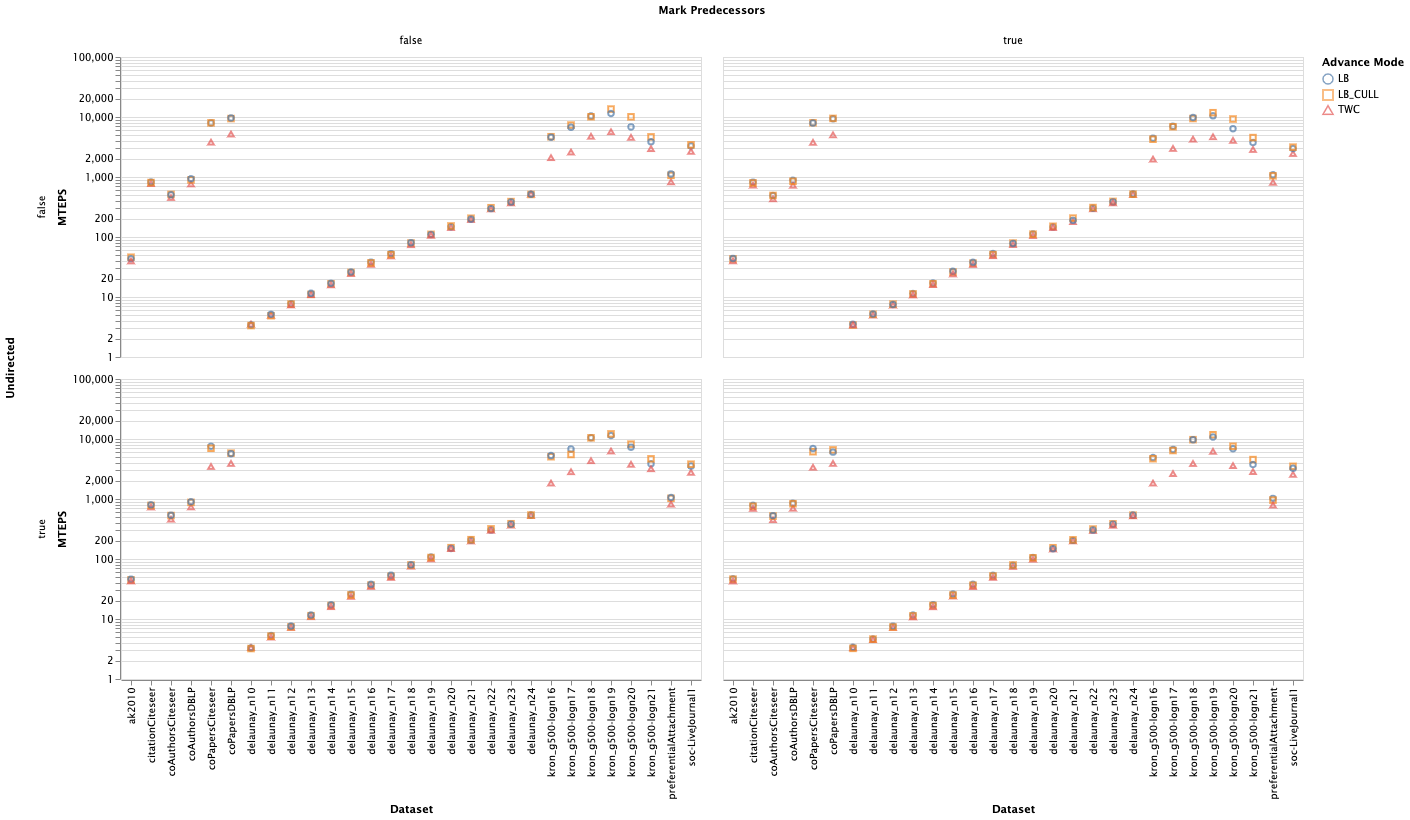

In [9]:
chart['full']